In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random

## Data Preprocessing:

In [2]:
adata = sc.read_h5ad("/vast/palmer/pi/xiting_yan/hw568/collections_spatial_datasets/spatialDLPFC_new/adata_vis_after.h5ad")

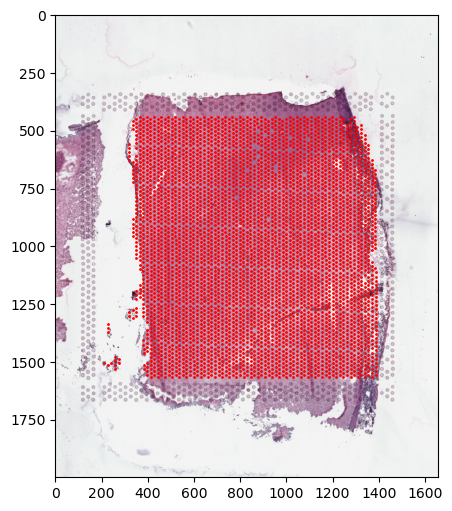

In [3]:
image = adata.uns['spatial']['Br6522_ant']['images']['hires']
row = adata.obsm['spatial'][adata.obs['sample_id'] == 'Br6522_ant', 0] * adata.uns['spatial']['Br6522_ant']['scalefactors']['tissue_hires_scalef']
col = adata.obsm['spatial'][adata.obs['sample_id'] == 'Br6522_ant', 1] * adata.uns['spatial']['Br6522_ant']['scalefactors']['tissue_hires_scalef']

plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.scatter(row, col, color='red', s=1)
plt.show()

In [4]:
spot_diameter_fullres = adata.uns['spatial']['Br6522_ant']['scalefactors']['spot_diameter_fullres']
spot_radius_full_res = spot_diameter_fullres/2
tissue_hires_scalef = adata.uns['spatial']['Br6522_ant']['scalefactors']['tissue_hires_scalef']
spot_radius_hires = spot_radius_full_res * tissue_hires_scalef

print(f"The radius of spot in high resolution image is {spot_radius_hires:.2f} pixels.")

The radius of spot in high resolution image is 5.77 pixels.


In [5]:
sample_id = "Br6522_ant"

# Extract spot coordinates
spots_coords = adata.obsm['spatial'][adata.obs['sample_id'] == sample_id]
spot_radius = 5.77

# Count the total number of spots
num_spots = len(spots_coords)

# Display the total number of spots
print(f"Sample ID: {sample_id}")
print(f"Total Number of Spots: {num_spots}")

Sample ID: Br6522_ant
Total Number of Spots: 4263


In [6]:
print(f"Image dimensions: Width = {image.shape[1]}, Height = {image.shape[0]}")

Image dimensions: Width = 1658, Height = 2000


This is clearly out of bounds, and needs to be scaled to match the pixel dimensions of the image.

In [7]:
scaling_factor_x = 1658 / np.max(spots_coords[:, 0])
scaling_factor_y = 2000 / np.max(spots_coords[:, 1])
spots_coords_scaled = spots_coords * [scaling_factor_x, scaling_factor_y]
print(f"Scaled Spots Range: Min X = {np.min(spots_coords_scaled[:, 0])}, Max X = {np.max(spots_coords_scaled[:, 0])}")
print(f"Scaled Spots Range: Min Y = {np.min(spots_coords_scaled[:, 1])}, Max Y = {np.max(spots_coords_scaled[:, 1])}")

Scaled Spots Range: Min X = 253.15847449782467, Max X = 1657.9999999999998
Scaled Spots Range: Min Y = 558.8632734122272, Max Y = 2000.0


## Feature Extraction:

### ViT

In [8]:
from PIL import Image
from transformers import ViTModel, ViTImageProcessor
import torch

model_name = "google/vit-base-patch16-224-in21k"
model = ViTModel.from_pretrained(model_name)  # Pre-trained Vision Transformer
processor = ViTImageProcessor.from_pretrained(model_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
model.eval()

# Extract features for selected spots
vector_representations = {}

with torch.no_grad():
    for idx, (x, y) in enumerate(spots_coords_scaled):
        start_x = max(0, int(x - spot_radius))
        end_x = min(image.shape[1], int(x + spot_radius))
        start_y = max(0, int(y - spot_radius))
        end_y = min(image.shape[0], int(y + spot_radius))
        
        if start_x >= end_x or start_y >= end_y:
            print(f"Skipping spot {idx+1}: Invalid crop boundaries.")
            continue
        
        # Crop the image
        cropped_image = image[start_y:end_y, start_x:end_x]
        cropped_pil = Image.fromarray((cropped_image * 255).astype(np.uint8))
        
        # Preprocess the image for ViT
        inputs = processor(images=cropped_pil, return_tensors="pt", size=(224, 224))
        inputs = {key: val.to(device) for key, val in inputs.items()}
        
        # Forward pass through ViT
        outputs = model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze(0).cpu().numpy()
        
        # Store the embedding
        vector_representations[f"spot_{idx+1}"] = cls_embedding

### PCA

In [9]:
from sklearn.decomposition import PCA

vectors = np.array(list(vector_representations.values()))

pca = PCA(n_components=50) 
pcs = pca.fit_transform(vectors)

pv1 = pca.components_[0]
pv2 = pca.components_[1]

# Store the principal components in a DataFrame
principalX = pd.DataFrame(data=pcs[:,:2], columns=['PC1', 'PC2'])

principalX.head(10)

,PC1,PC2
0,-2.300614,1.023799
1,0.352777,-1.670898
2,-2.373690,1.021301
3,3.593609,0.635153
4,3.587901,0.634733
5,2.577854,-0.348188
6,3.548558,0.559540
7,0.646634,-2.937982
8,-2.120048,0.328270
9,-2.395325,0.715087


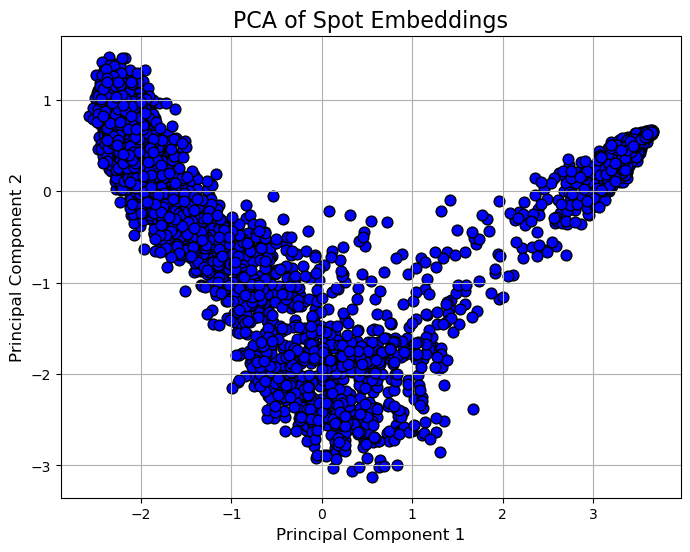

In [10]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

vectors = np.array(list(vector_representations.values()))

pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(vectors)

plt.figure(figsize=(8, 6))
plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c='blue', edgecolor='k', s=60)
plt.title("PCA of Spot Embeddings", fontsize=16)
plt.xlabel("Principal Component 1", fontsize=12)
plt.ylabel("Principal Component 2", fontsize=12)
plt.grid(True)
plt.show()

There are 4 types of Manual Annotation, so we set K=4.

## K Means Clustering

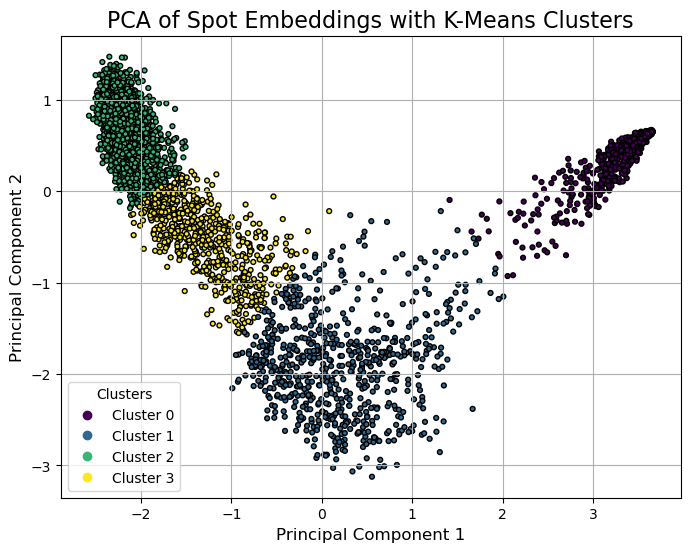

In [11]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# Assuming reduced_vectors is already computed (PCA-reduced data)
kmeans = KMeans(n_clusters=4)
clusters = kmeans.fit_predict(reduced_vectors)  # Converts to discrete variable (cluster labels)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    reduced_vectors[:, 0], 
    reduced_vectors[:, 1], 
    c=clusters, 
    cmap='viridis', 
    edgecolor='k', 
    s=12
)

# Generate legend with cluster annotations
unique_labels = np.unique(clusters)
handles = [
    plt.Line2D([], [], marker='o', linestyle='', color=scatter.cmap(scatter.norm(label)), label=f"Cluster {label}")
    for label in unique_labels
]

plt.legend(handles=handles, title="Clusters")
plt.title("PCA of Spot Embeddings with K-Means Clusters", fontsize=16)
plt.xlabel("Principal Component 1", fontsize=12)
plt.ylabel("Principal Component 2", fontsize=12)
plt.grid(True)
plt.show()

## Annotation Data Clean

### UMAP

In [13]:
# Filter rows where sample_id is 'Br6522_ant'
filtered_data = adata.obs[adata.obs['sample_id'] == 'Br6522_ant'][['sample_id', 'key']]
filtered_data['key'] = filtered_data['key'].str.split('_').str[0]
filtered_data.rename(columns={'key': 'spot_name'}, inplace=True)
print(filtered_data)

                                sample_id           spot_name
AAACAAGTATCTCCCA-1_Br6522_ant  Br6522_ant  AAACAAGTATCTCCCA-1
AAACACCAATAACTGC-1_Br6522_ant  Br6522_ant  AAACACCAATAACTGC-1
AAACAGAGCGACTCCT-1_Br6522_ant  Br6522_ant  AAACAGAGCGACTCCT-1
AAACAGCTTTCAGAAG-1_Br6522_ant  Br6522_ant  AAACAGCTTTCAGAAG-1
AAACAGGGTCTATATT-1_Br6522_ant  Br6522_ant  AAACAGGGTCTATATT-1
AAACAGTGTTCCTGGG-1_Br6522_ant  Br6522_ant  AAACAGTGTTCCTGGG-1
AAACATGGTGAGAGGA-1_Br6522_ant  Br6522_ant  AAACATGGTGAGAGGA-1
AAACATTTCCCGGATT-1_Br6522_ant  Br6522_ant  AAACATTTCCCGGATT-1
AAACCCGAACGAAATC-1_Br6522_ant  Br6522_ant  AAACCCGAACGAAATC-1
AAACCGGAAATGTTAA-1_Br6522_ant  Br6522_ant  AAACCGGAAATGTTAA-1
AAACCGGGTAGGTACC-1_Br6522_ant  Br6522_ant  AAACCGGGTAGGTACC-1
AAACCGTTCGTCCAGG-1_Br6522_ant  Br6522_ant  AAACCGTTCGTCCAGG-1
AAACCTAAGCAGCCGG-1_Br6522_ant  Br6522_ant  AAACCTAAGCAGCCGG-1
AAACCTCATGAAGTTG-1_Br6522_ant  Br6522_ant  AAACCTCATGAAGTTG-1
AAACGAAGATGGAGTA-1_Br6522_ant  Br6522_ant  AAACGAAGATGGAGTA-1
AAACGAGA

In [14]:
# Perform the merge using filtered_data as the base to retain sample_id
merged_data = filtered_data.merge(annotation_data, on='spot_name', how='left')

merged_data['ManualAnnotation'] = merged_data['ManualAnnotation'].fillna('normal')
merged_data = merged_data.rename(columns={'sample_id_x': 'sample_id'}).drop(columns=['sample_id_y'], errors='ignore')
final_data = merged_data[['sample_id', 'spot_name', 'ManualAnnotation']]
print(final_data)

       sample_id           spot_name ManualAnnotation
0     Br6522_ant  AAACAAGTATCTCCCA-1           normal
1     Br6522_ant  AAACACCAATAACTGC-1           normal
2     Br6522_ant  AAACAGAGCGACTCCT-1           normal
3     Br6522_ant  AAACAGCTTTCAGAAG-1           normal
4     Br6522_ant  AAACAGGGTCTATATT-1           normal
5     Br6522_ant  AAACAGTGTTCCTGGG-1           normal
6     Br6522_ant  AAACATGGTGAGAGGA-1           normal
7     Br6522_ant  AAACATTTCCCGGATT-1           normal
8     Br6522_ant  AAACCCGAACGAAATC-1           normal
9     Br6522_ant  AAACCGGAAATGTTAA-1           normal
10    Br6522_ant  AAACCGGGTAGGTACC-1           normal
11    Br6522_ant  AAACCGTTCGTCCAGG-1           normal
12    Br6522_ant  AAACCTAAGCAGCCGG-1           normal
13    Br6522_ant  AAACCTCATGAAGTTG-1           normal
14    Br6522_ant  AAACGAAGATGGAGTA-1           normal
15    Br6522_ant  AAACGAGACGGTTGAT-1           normal
16    Br6522_ant  AAACGCTGGGCACGAC-1             Fold
17    Br6522_ant  AAACGGGCGT

/home/ll2276/.conda/envs/new_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


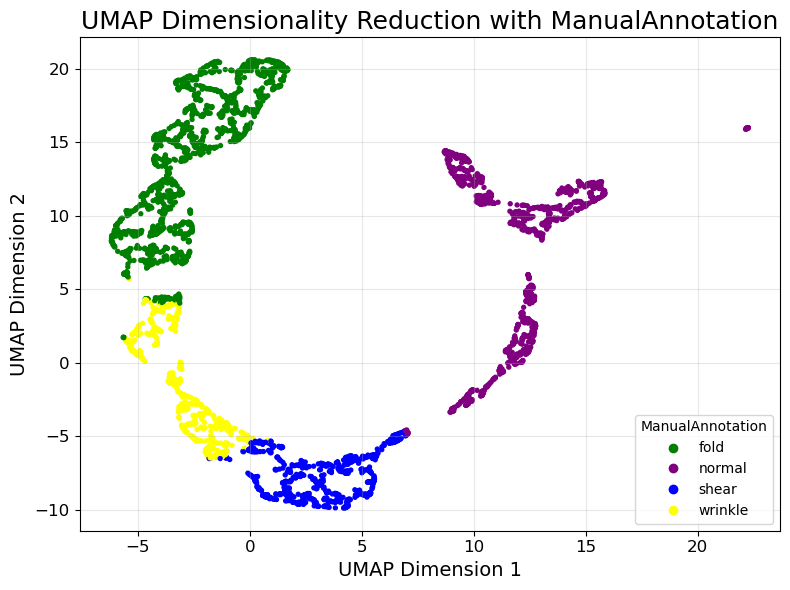

In [15]:
from umap import UMAP
import matplotlib.pyplot as plt
import numpy as np

# Perform UMAP dimensionality reduction
umap = UMAP(n_components=2, n_neighbors=15, min_dist=0.05, random_state=42)
umap_results = umap.fit_transform(reduced_vectors)

# Manually map clusters to ManualAnnotation labels
cluster_mapping = {
    0: 'normal',
    1: 'shear',
    2: 'fold',
    3: 'wrinkle'
}
manual_annotations = np.array([cluster_mapping[cluster] for cluster in clusters])

# Define custom colors: purple, blue, green, yellow
color_mapping = {
    'normal': 'purple',
    'shear': 'blue',
    'fold': 'green',
    'wrinkle': 'yellow'
}

# Map annotations to custom colors
colors = [color_mapping[label] for label in manual_annotations]

# Plot UMAP results
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    umap_results[:, 0], 
    umap_results[:, 1], 
    c=colors,  # Apply custom colors
    s=8  # Marker size
)

# Generate legend for ManualAnnotation labels
unique_labels = np.unique(manual_annotations)
handles = [
    plt.Line2D([], [], marker='o', linestyle='', markersize=6, 
               color=color_mapping[label]) 
    for label in unique_labels
]
plt.legend(handles, unique_labels, title="ManualAnnotation", loc='best')

# Add plot titles and labels
plt.title("UMAP Dimensionality Reduction with ManualAnnotation", fontsize=18)
plt.xlabel("UMAP Dimension 1", fontsize=14)
plt.ylabel("UMAP Dimension 2", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


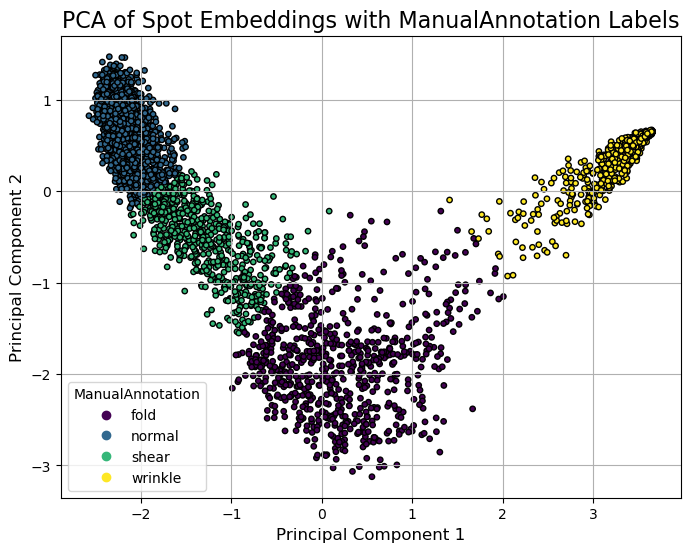

In [16]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# Assuming reduced_vectors is already computed (PCA-reduced data)
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(reduced_vectors)  # Converts to discrete variable (cluster labels)

# Create a manual mapping for clusters to ManualAnnotation labels
# Ensure this matches your data structure; adjust as needed
cluster_mapping = {
    0: 'normal',
    1: 'shear',
    2: 'fold',
    3: 'wrinkle'
}

# Replace clusters with their corresponding ManualAnnotation labels
manual_annotations = np.array([cluster_mapping[cluster] for cluster in clusters])

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    reduced_vectors[:, 0], 
    reduced_vectors[:, 1], 
    c=[['normal', 'shear', 'fold', 'wrinkle'].index(label) for label in manual_annotations],  # Convert to numerical for coloring
    cmap='viridis', 
    edgecolor='k', 
    s=15
)

# Generate legend with ManualAnnotation labels
unique_labels = np.unique(manual_annotations)
handles = [
    plt.Line2D([], [], marker='o', linestyle='', color=scatter.cmap(scatter.norm(i)), label=label)
    for i, label in enumerate(unique_labels)
]

plt.legend(handles=handles, title="ManualAnnotation")
plt.title("PCA of Spot Embeddings with ManualAnnotation Labels", fontsize=16)
plt.xlabel("Principal Component 1", fontsize=12)
plt.ylabel("Principal Component 2", fontsize=12)
plt.grid(True)
plt.show()

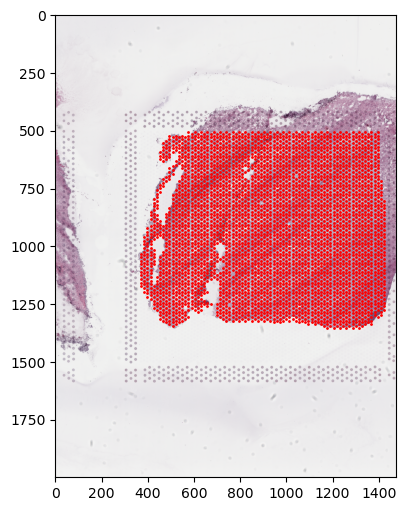

In [17]:
Br6522_mid_image = adata.uns['spatial']['Br6522_mid']['images']['hires']
row_mid = adata.obsm['spatial'][adata.obs['sample_id'] == 'Br6522_mid', 0] * adata.uns['spatial']['Br6522_mid']['scalefactors']['tissue_hires_scalef']
col_mid = adata.obsm['spatial'][adata.obs['sample_id'] == 'Br6522_mid', 1] * adata.uns['spatial']['Br6522_mid']['scalefactors']['tissue_hires_scalef']

plt.figure(figsize=(6, 6))
plt.imshow(Br6522_mid_image)
plt.scatter(row_mid, col_mid, color='red', s=1)
plt.show()

In [18]:
sample_id = "Br6522_mid"

# Extract spot coordinates
spots_coords = adata.obsm['spatial'][adata.obs['sample_id'] == sample_id]
spot_radius = 5.77

# Count the total number of spots
num_spots = len(spots_coords)

# Display the total number of spots
print(f"Sample ID: {sample_id}")
print(f"Total Number of Spots: {num_spots}")

Sample ID: Br6522_mid
Total Number of Spots: 3724


In [19]:
scaling_factor_x1 = 1658 / np.max(spots_coords[:, 0])
scaling_factor_y1 = 2000 / np.max(spots_coords[:, 1])
spots_coords_scaled1 = spots_coords * [scaling_factor_x1, scaling_factor_y1]
print(f"Scaled Spots Range: Min X = {np.min(spots_coords_scaled1[:, 0])}, Max X = {np.max(spots_coords_scaled1[:, 0])}")
print(f"Scaled Spots Range: Min Y = {np.min(spots_coords_scaled1[:, 1])}, Max Y = {np.max(spots_coords_scaled1[:, 1])}")

Scaled Spots Range: Min X = 432.3360805135114, Max X = 1658.0
Scaled Spots Range: Min Y = 746.2275948311797, Max Y = 2000.0


In [20]:
from PIL import Image
from transformers import ViTModel, ViTImageProcessor
import torch

model_name = "google/vit-base-patch16-224-in21k"
model = ViTModel.from_pretrained(model_name)  # Pre-trained Vision Transformer
processor = ViTImageProcessor.from_pretrained(model_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
model.eval()

# Extract features for selected spots
vector_representations1 = {}

with torch.no_grad():
    for idx, (x, y) in enumerate(spots_coords_scaled1):
        start_x = max(0, int(x - spot_radius))
        end_x = min(image.shape[1], int(x + spot_radius))
        start_y = max(0, int(y - spot_radius))
        end_y = min(image.shape[0], int(y + spot_radius))
        
        if start_x >= end_x or start_y >= end_y:
            print(f"Skipping spot {idx+1}: Invalid crop boundaries.")
            continue
        
        # Crop the image
        cropped_image = image[start_y:end_y, start_x:end_x]
        cropped_pil = Image.fromarray((cropped_image * 255).astype(np.uint8))
        
        # Preprocess the image for ViT
        inputs = processor(images=cropped_pil, return_tensors="pt", size=(224, 224))
        inputs = {key: val.to(device) for key, val in inputs.items()}
        
        # Forward pass through ViT
        outputs = model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze(0).cpu().numpy()
        
        # Store the embedding
        vector_representations1[f"spot_{idx+1}"] = cls_embedding

In [21]:
from sklearn.decomposition import PCA
vectors1 = np.array(list(vector_representations1.values()))

pca = PCA(n_components=50) 
pcs = pca.fit_transform(vectors1)

pv1 = pca.components_[0]
pv2 = pca.components_[1]

# Store the principal components in a DataFrame
principalX1 = pd.DataFrame(data=pcs[:,:2], columns=['PC1', 'PC2'])


In [22]:
vectors1 = np.array(list(vector_representations1.values()))

pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(vectors1)

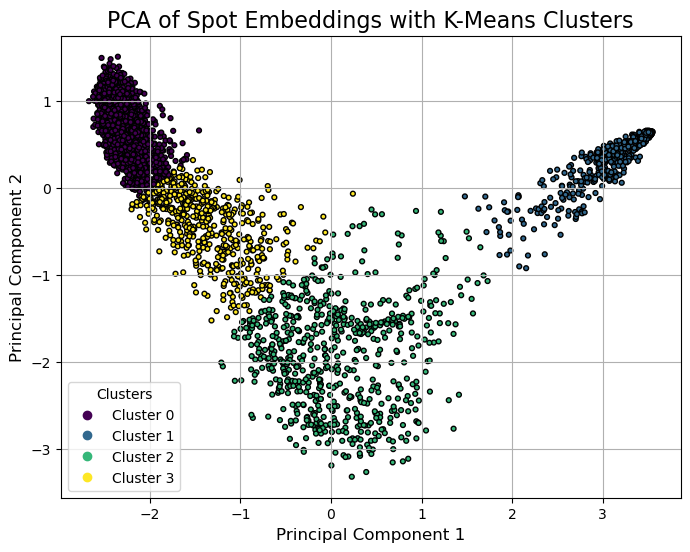

In [23]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# Assuming reduced_vectors is already computed (PCA-reduced data)
kmeans = KMeans(n_clusters=4)
clusters = kmeans.fit_predict(reduced_vectors)  # Converts to discrete variable (cluster labels)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    reduced_vectors[:, 0], 
    reduced_vectors[:, 1], 
    c=clusters, 
    cmap='viridis', 
    edgecolor='k', 
    s=12
)

# Generate legend with cluster annotations
unique_labels = np.unique(clusters)
handles = [
    plt.Line2D([], [], marker='o', linestyle='', color=scatter.cmap(scatter.norm(label)), label=f"Cluster {label}")
    for label in unique_labels
]

plt.legend(handles=handles, title="Clusters")
plt.title("PCA of Spot Embeddings with K-Means Clusters", fontsize=16)
plt.xlabel("Principal Component 1", fontsize=12)
plt.ylabel("Principal Component 2", fontsize=12)
plt.grid(True)
plt.show()

/home/ll2276/.conda/envs/new_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


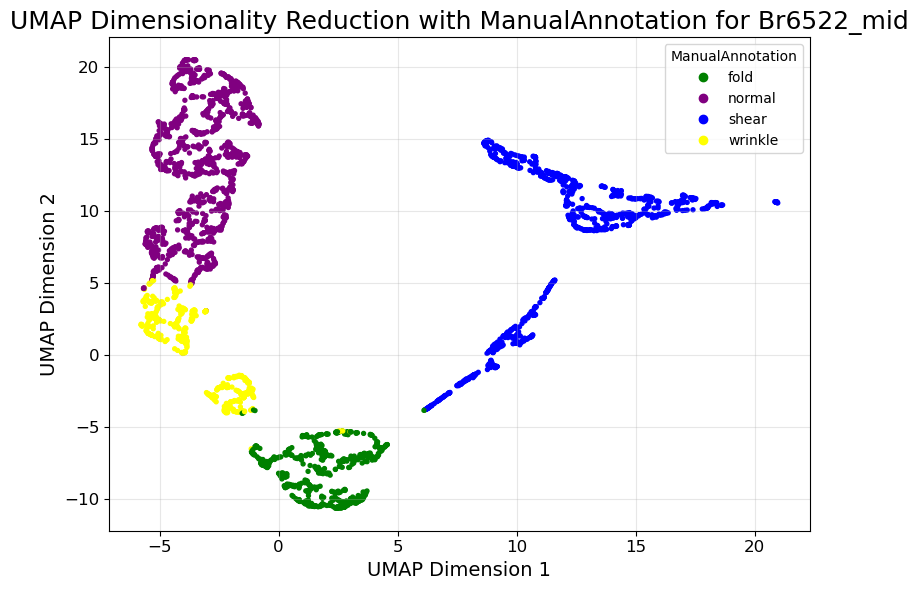

In [24]:
from umap import UMAP
import matplotlib.pyplot as plt
import numpy as np

# Perform UMAP dimensionality reduction for the Br6522_mid sample
umap_reducer = UMAP(n_components=2, n_neighbors=15, min_dist=0.05, random_state=42)
umap_results = umap_reducer.fit_transform(reduced_vectors)

# Manually map clusters to ManualAnnotation labels
cluster_mapping = {
    0: 'normal',
    1: 'shear',
    2: 'fold',
    3: 'wrinkle'
}
manual_annotations = np.array([cluster_mapping[cluster] for cluster in clusters])

# Define custom colors: purple, blue, green, yellow
color_mapping = {
    'normal': 'purple',
    'shear': 'blue',
    'fold': 'green',
    'wrinkle': 'yellow'
}

# Map annotations to custom colors
colors = [color_mapping[label] for label in manual_annotations]

# Plot UMAP results with the custom colors
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    umap_results[:, 0],
    umap_results[:, 1],
    c=colors,  # Apply custom colors
    s=8       # Marker size
)

# Generate legend for ManualAnnotation labels
unique_labels = np.unique(manual_annotations)
handles = [
    plt.Line2D([], [], marker='o', linestyle='', markersize=6, color=color_mapping[label])
    for label in unique_labels
]
plt.legend(handles, unique_labels, title="ManualAnnotation", loc='best')

# Add plot titles and labels
plt.title("UMAP Dimensionality Reduction with ManualAnnotation for Br6522_mid", fontsize=18)
plt.xlabel("UMAP Dimension 1", fontsize=14)
plt.ylabel("UMAP Dimension 2", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


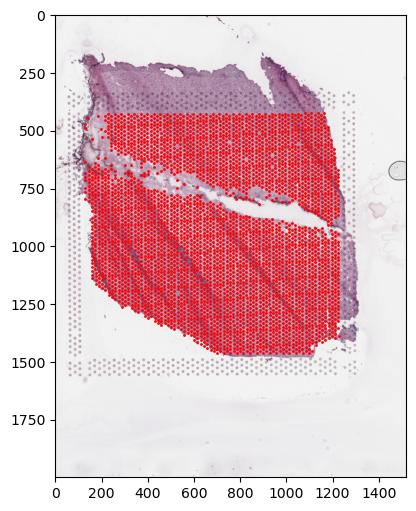

In [25]:
Br8667_post_image = adata.uns['spatial']['Br8667_post']['images']['hires']
row_post = adata.obsm['spatial'][adata.obs['sample_id'] == 'Br8667_post', 0] * adata.uns['spatial']['Br8667_post']['scalefactors']['tissue_hires_scalef']
col_post = adata.obsm['spatial'][adata.obs['sample_id'] == 'Br8667_post', 1] * adata.uns['spatial']['Br8667_post']['scalefactors']['tissue_hires_scalef']

plt.figure(figsize=(6, 6))
plt.imshow(Br8667_post_image)
plt.scatter(row_post, col_post, color='red', s=1)
plt.show()

In [26]:
sample_id = "Br8667_post"

# Extract spot coordinates for Br8667_post
spots_coords = adata.obsm['spatial'][adata.obs['sample_id'] == sample_id]
spot_radius = 5.77

# Count the total number of spots
num_spots = len(spots_coords)
print(f"Sample ID: {sample_id}")
print(f"Total Number of Spots: {num_spots}")

# Compute scaling factors based on the image dimensions (example values)
scaling_factor_x = 1658 / np.max(spots_coords[:, 0])
scaling_factor_y = 2000 / np.max(spots_coords[:, 1])
spots_coords_scaled = spots_coords * [scaling_factor_x, scaling_factor_y]
print(f"Scaled Spots Range: Min X = {np.min(spots_coords_scaled[:, 0])}, Max X = {np.max(spots_coords_scaled[:, 0])}")
print(f"Scaled Spots Range: Min Y = {np.min(spots_coords_scaled[:, 1])}, Max Y = {np.max(spots_coords_scaled[:, 1])}")

# Load the pre-trained Vision Transformer model and image processor
from PIL import Image
from transformers import ViTModel, ViTImageProcessor
import torch

model_name = "google/vit-base-patch16-224-in21k"
model = ViTModel.from_pretrained(model_name)
processor = ViTImageProcessor.from_pretrained(model_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
model.eval()

# Extract features for each spot
vector_representations2 = {}

with torch.no_grad():
    for idx, (x, y) in enumerate(spots_coords_scaled):
        start_x = max(0, int(x - spot_radius))
        end_x = min(image.shape[1], int(x + spot_radius))
        start_y = max(0, int(y - spot_radius))
        end_y = min(image.shape[0], int(y + spot_radius))
        
        if start_x >= end_x or start_y >= end_y:
            print(f"Skipping spot {idx+1}: Invalid crop boundaries.")
            continue
        
        # Crop the image for the current spot
        cropped_image = image[start_y:end_y, start_x:end_x]
        cropped_pil = Image.fromarray((cropped_image * 255).astype(np.uint8))
        
        # Preprocess the cropped image for ViT
        inputs = processor(images=cropped_pil, return_tensors="pt", size=(224, 224))
        inputs = {key: val.to(device) for key, val in inputs.items()}
        
        # Get the CLS embedding from ViT
        outputs = model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze(0).cpu().numpy()
        
        # Store the embedding using a unique key
        vector_representations2[f"spot_{idx+1}"] = cls_embedding

Sample ID: Br8667_post
Total Number of Spots: 4025
Scaled Spots Range: Min X = 173.9483586100979, Max X = 1657.9999999999998
Scaled Spots Range: Min Y = 580.105385945859, Max Y = 2000.0


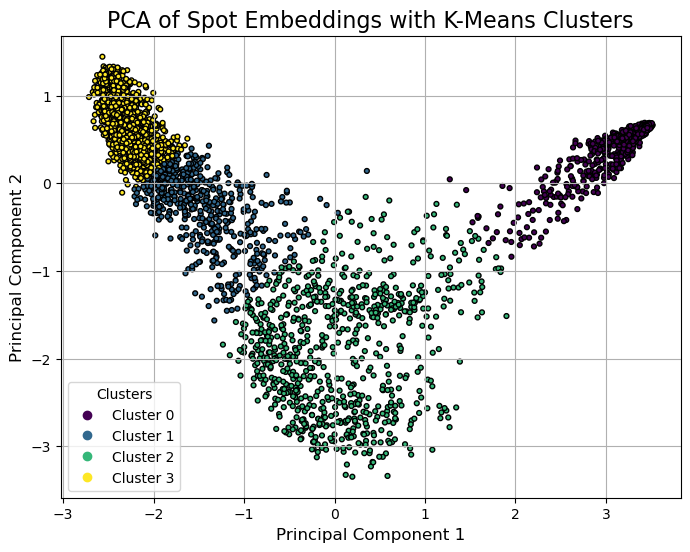

In [27]:
# Reduce dimensions using PCA
from sklearn.decomposition import PCA
import pandas as pd

vectors2 = np.array(list(vector_representations2.values()))

# First PCA: 50 components (for potential further analysis)
pca_50 = PCA(n_components=50)
pcs = pca_50.fit_transform(vectors2)
principalX = pd.DataFrame(data=pcs[:, :2], columns=['PC1', 'PC2'])

# Second PCA: Reduce to 2 dimensions for clustering and visualization
pca_2 = PCA(n_components=2)
reduced_vectors = pca_2.fit_transform(vectors2)

# Apply KMeans clustering on the reduced vectors
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(reduced_vectors)

# Plot the PCA of spot embeddings with KMeans clusters
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    reduced_vectors[:, 0], 
    reduced_vectors[:, 1], 
    c=clusters, 
    cmap='viridis', 
    edgecolor='k', 
    s=12
)

# Generate legend with cluster annotations
unique_labels = np.unique(clusters)
handles = [
    plt.Line2D([], [], marker='o', linestyle='', color=scatter.cmap(scatter.norm(label)), label=f"Cluster {label}")
    for label in unique_labels
]

plt.legend(handles=handles, title="Clusters")
plt.title("PCA of Spot Embeddings with K-Means Clusters", fontsize=16)
plt.xlabel("Principal Component 1", fontsize=12)
plt.ylabel("Principal Component 2", fontsize=12)
plt.grid(True)
plt.show()

/home/ll2276/.conda/envs/new_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


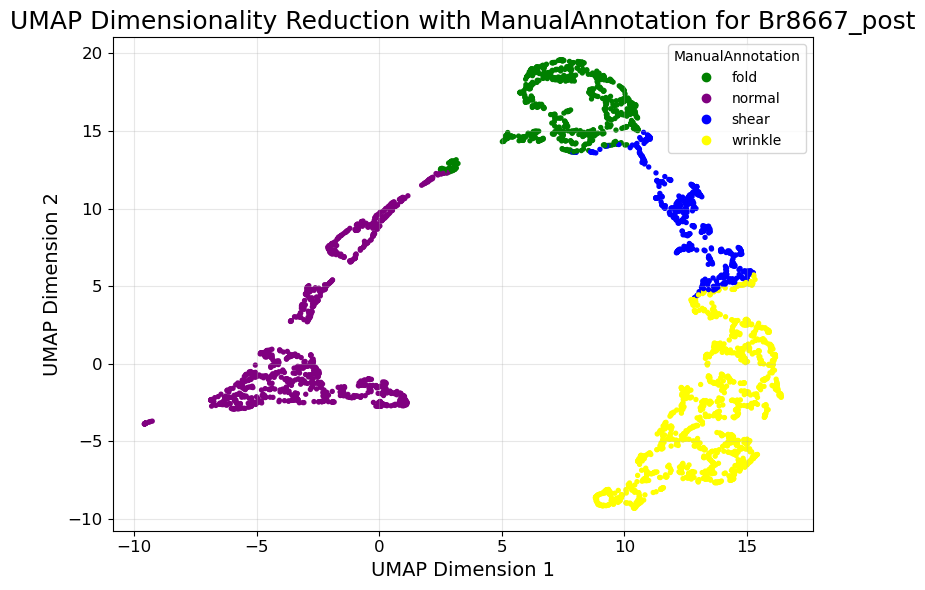

In [28]:
from umap import UMAP
import matplotlib.pyplot as plt
import numpy as np

# Perform UMAP dimensionality reduction for the Br8667_post sample
umap_reducer = UMAP(n_components=2, n_neighbors=15, min_dist=0.05, random_state=42)
umap_results = umap_reducer.fit_transform(reduced_vectors)

# Manually map clusters to ManualAnnotation labels
cluster_mapping = {
    0: 'normal',
    1: 'shear',
    2: 'fold',
    3: 'wrinkle'
}
manual_annotations = np.array([cluster_mapping[cluster] for cluster in clusters])

# Define custom colors for each ManualAnnotation: purple, blue, green, yellow
color_mapping = {
    'normal': 'purple',
    'shear': 'blue',
    'fold': 'green',
    'wrinkle': 'yellow'
}

# Map annotations to custom colors
colors = [color_mapping[label] for label in manual_annotations]

# Plot UMAP results with the custom colors
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    umap_results[:, 0], 
    umap_results[:, 1], 
    c=colors,  # Apply custom colors
    s=8       # Marker size
)

# Generate legend for ManualAnnotation labels
unique_labels = np.unique(manual_annotations)
handles = [
    plt.Line2D([], [], marker='o', linestyle='', markersize=6, color=color_mapping[label])
    for label in unique_labels
]
plt.legend(handles, unique_labels, title="ManualAnnotation", loc='best')

# Add plot titles and labels
plt.title("UMAP Dimensionality Reduction with ManualAnnotation for Br8667_post", fontsize=18)
plt.xlabel("UMAP Dimension 1", fontsize=14)
plt.ylabel("UMAP Dimension 2", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Final UMAP

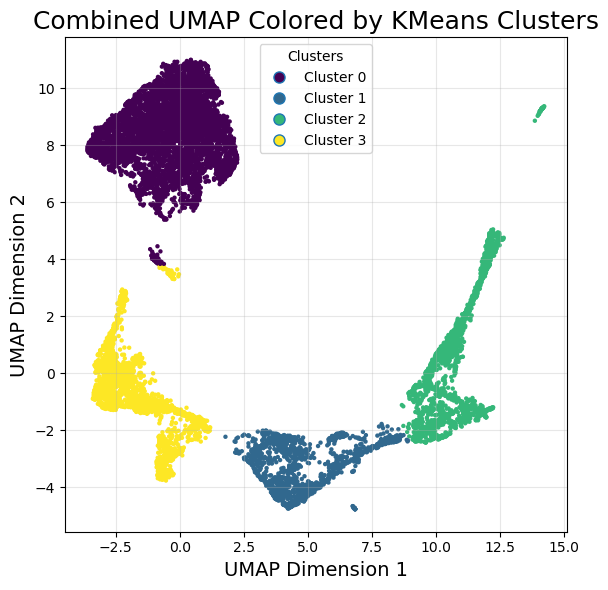

In [32]:
# ----------------------------------------
# Figure 1: Color by KMeans Clusters
# ----------------------------------------
plt.figure(figsize=(6, 6))
sc1 = plt.scatter(
    umap_all[:, 0],
    umap_all[:, 1],
    c=clusters_all,            # Directly use KMeans cluster IDs
    cmap='viridis',            # Choose a colormap (e.g., viridis)
    s=10,
    lw=0
)
plt.title("Combined UMAP Colored by KMeans Clusters", fontsize=18)
plt.xlabel("UMAP Dimension 1", fontsize=14)
plt.ylabel("UMAP Dimension 2", fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Create legend for clusters
unique_clusters = np.unique(clusters_all)
handles1 = [
    plt.Line2D([], [], marker='o', linestyle='', markersize=8,
               markerfacecolor=sc1.cmap(sc1.norm(clust)), label=f"Cluster {clust}")
    for clust in unique_clusters
]
plt.legend(handles=handles1, title="Clusters", loc='best')
plt.show()

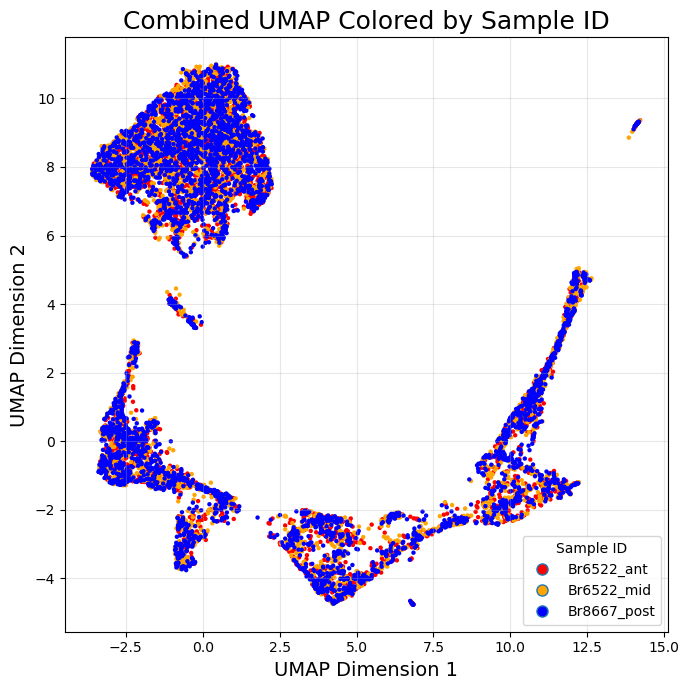

In [36]:
all_vectors = np.concatenate((vectors, vectors1, vectors2), axis=0)

# Create an array of sample labels for each spot
labels_ant = np.repeat("Br6522_ant", vectors.shape[0])
labels_mid = np.repeat("Br6522_mid", vectors1.shape[0])
labels_post = np.repeat("Br8667_post", vectors2.shape[0])
all_labels = np.concatenate((labels_ant, labels_mid, labels_post), axis=0)
# Define a mapping of sample IDs to custom colors
sample_color_mapping = {
    "Br6522_ant": "red",
    "Br6522_mid": "orange",
    "Br8667_post": "blue"
}

# Map each sample label to its corresponding color
colors_sample = [sample_color_mapping[label] for label in all_labels]

plt.figure(figsize=(7, 7))
sc2 = plt.scatter(
    umap_all[:, 0],
    umap_all[:, 1],
    c=colors_sample,
    s=10,
    lw=0
)
plt.title("Combined UMAP Colored by Sample ID", fontsize=18)
plt.xlabel("UMAP Dimension 1", fontsize=14)
plt.ylabel("UMAP Dimension 2", fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Create legend for samples
unique_samples = np.unique(all_labels)
handles2 = [
    plt.Line2D([], [], marker='o', linestyle='', markersize=8,
               markerfacecolor=sample_color_mapping[sample], label=sample)
    for sample in unique_samples
]
plt.legend(handles=handles2, title="Sample ID", loc='best')
plt.show()

# adata_vis_human_spatial_paper.h5ad

In [2]:
adata1 = sc.read_h5ad("/vast/palmer/pi/xiting_yan/hw568/collections_spatial_datasets/Visium_IPF_Fidel/adata_vis_human_spatial_paper.h5ad")

### Gather sample_id

In [3]:
sample_ids = list(adata1.uns['spatial'].keys())
print("Found sample IDs in adata1:", sample_ids)

Found sample IDs in adata1: ['1217_0001_processed_aligned', '1217_0002_processed_aligned', '1217_0003_processed_aligned', '1217_0004_processed_aligned', '90_A1_H237762_IPF_processed_CM', '90_C1_RO-730_Healthy_processed_CM', '91_A1_RO-727_Healthy_processed_CM', '91_B1_RO-728_Healthy_processed_CM', '91_D1_24513-17_IPF_processed_CM', '92_A1_RO-3203_Healthy_processed_CM', '92_D1_RO-3736_IPF_processed_CM']


In [17]:
adata1.uns['spatial']

{'1217_0001_processed_aligned': {'images': {'hires': array([[[0.07058824, 0.04313726, 0.03921569],
           [0.0627451 , 0.03921569, 0.03529412],
           [0.07843138, 0.04705882, 0.04705882],
           ...,
           [0.08627451, 0.05882353, 0.04313726],
           [0.08235294, 0.05882353, 0.03921569],
           [0.08235294, 0.05490196, 0.03921569]],
   
          [[0.13725491, 0.10196079, 0.08627451],
           [0.13333334, 0.09803922, 0.08627451],
           [0.14509805, 0.10588235, 0.09019608],
           ...,
           [0.07843138, 0.05098039, 0.03921569],
           [0.07450981, 0.04705882, 0.03529412],
           [0.0627451 , 0.04705882, 0.03137255]],
   
          [[0.15686275, 0.11372549, 0.09411765],
           [0.16470589, 0.12156863, 0.10196079],
           [0.16862746, 0.1254902 , 0.10196079],
           ...,
           [0.0627451 , 0.04313726, 0.02745098],
           [0.0627451 , 0.03921569, 0.02745098],
           [0.05490196, 0.03529412, 0.02352941]],
   
     

In [19]:
adata1

AnnData object with n_obs × n_vars = 57787 × 12486
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'leiden_25', 'sampleID', 'treatment', 'VisiumSlides', 'technology', 'patient', 'AT0', 'AT1', 'AT2', 'Aberrant basaloid', 'Adventitial fibroblast', 'Alveolar fibroblast', 'Artery', 'B/Plasma', 'Basal', 'Basophil/Mast', 'Bronchial Vessel', 'Capillary', 'Capillary Aerocyte', 'Ciliated', 'Ciliated SFTPB+/SCGB1A1+', 'Dendritic', 'Ionocyte', 'Lymphatic', 'Macrophage C1Q hi', 'Macrophage CHI3L1+/CD9 hi/', 'Macrophage FABP4+', 'Macrophage IL1B+', 'Macrophage LYVE1+', 'Macrophage RETN+/VCAN+', 'Mesothelial', 'Monocyte', 'Mucous', 'Myofibroblast', 'NK', 'Peribronchial fibroblast', 'Pericyte', 'Smooth Muscle', 'T cell', 'TB-SC', 'Vein', 'pDC', 'preTB-SC/RAS', 'Androgen', 'EGFRsignaling', 'Estrogen', 'Hypoxia', 'JAK-STAT', 'MAPK', 'NFkB', 'p53', 'PI3K', 'TGFb', 'TNFa', 'Trail', 'VEGF', 'WNT', 'mean_nUMI_fa

In [18]:
adata1.obsm['spatial']

array([[6601, 3200],
       [7526, 8027],
       [5908, 8613],
       ...,
       [1719, 1260],
       [1288, 2115],
       [1492, 2171]])

### Retrieve Embeddings for Each Sample

In [4]:
import scanpy as sc
import numpy as np
from sklearn.decomposition import PCA

# Load the two AnnData objects
adata = sc.read_h5ad("/vast/palmer/pi/xiting_yan/hw568/collections_spatial_datasets/spatialDLPFC_new/adata_vis_after.h5ad")
adata1 = sc.read_h5ad("/vast/palmer/pi/xiting_yan/hw568/collections_spatial_datasets/Visium_IPF_Fidel/adata_vis_human_spatial_paper.h5ad")

# Define the target sample IDs for each dataset
target_samples_adata = ["Br6522_ant", "Br6522_mid", "Br8667_post"]
target_samples_adata1 = [
    "1217_0001_processed_aligned",
    "1217_0002_processed_aligned",
    "1217_0003_processed_aligned",
    "1217_0004_processed_aligned",
    "90_A1_H237762_IPF_processed_CM",
    "90_C1_RO-730_Healthy_processed_CM",
    "91_A1_RO-727_Healthy_processed_CM",
    "91_B1_RO-728_Healthy_processed_CM",
    "91_D1_24513-17_IPF_processed_CM",
    "92_A1_RO-3203_Healthy_processed_CM",
    "92_D1_RO-3736_IPF_processed_CM"
]

# Initialize lists to hold combined features and corresponding sample labels
all_vectors_list = []
all_labels_list = []

def process_samples(adata_obj, target_samples, sample_column="sample_id"):
    for sample_id in target_samples:
        # Create a mask for spots belonging to this sample
        mask = (adata_obj.obs[sample_column] == sample_id)
        num_spots = np.sum(mask)
        print(f"Processing sample {sample_id} with {num_spots} spots.")
        
        # Extract the expression/feature matrix for these spots
        sample_data = adata_obj.X[mask]
        if hasattr(sample_data, "toarray"):
            sample_data = sample_data.toarray()
        
        # Run PCA to reduce expression dimensions to 50 components
        pca = PCA(n_components=50, random_state=42)
        sample_pca = pca.fit_transform(sample_data)
        
        # Extract spatial coordinates and scale them
        spots_coords = adata_obj.obsm['spatial'][mask]
        scaling_factor_x = 1658 / np.max(spots_coords[:, 0])
        scaling_factor_y = 2000 / np.max(spots_coords[:, 1])
        spots_coords_scaled = spots_coords * np.array([scaling_factor_x, scaling_factor_y])
        
        # Combine the PCA embeddings with the scaled spatial coordinates (50 + 2 features)
        combined_features = np.concatenate([sample_pca, spots_coords_scaled], axis=1)
        
        all_vectors_list.append(combined_features)
        all_labels_list.append([sample_id] * combined_features.shape[0])

# Process samples in adata (spatialDLPFC_new)
process_samples(adata, target_samples_adata, sample_column="sample_id")

# Process samples in adata1 (Visium_IPF_Fidel)
# Use "sample_id" if available; otherwise, fallback to "sample"
if "sample_id" in adata1.obs.columns:
    process_samples(adata1, target_samples_adata1, sample_column="sample_id")
else:
    process_samples(adata1, target_samples_adata1, sample_column="sample")

# Concatenate embeddings and labels from both datasets
all_vectors = np.concatenate(all_vectors_list, axis=0)
all_labels = np.concatenate(all_labels_list, axis=0)
print("Combined embedding shape:", all_vectors.shape)


Processing sample Br6522_ant with 4263 spots.
Processing sample Br6522_mid with 3724 spots.
Processing sample Br8667_post with 4025 spots.
Processing sample 1217_0001_processed_aligned with 10728 spots.
Processing sample 1217_0002_processed_aligned with 8624 spots.
Processing sample 1217_0003_processed_aligned with 12107 spots.
Processing sample 1217_0004_processed_aligned with 8206 spots.
Processing sample 90_A1_H237762_IPF_processed_CM with 2793 spots.
Processing sample 90_C1_RO-730_Healthy_processed_CM with 2877 spots.
Processing sample 91_A1_RO-727_Healthy_processed_CM with 2377 spots.
Processing sample 91_B1_RO-728_Healthy_processed_CM with 2448 spots.
Processing sample 91_D1_24513-17_IPF_processed_CM with 3284 spots.
Processing sample 92_A1_RO-3203_Healthy_processed_CM with 2412 spots.
Processing sample 92_D1_RO-3736_IPF_processed_CM with 1931 spots.
Combined embedding shape: (69799, 52)


### Draw a UMAP